


















# Humbpack Whale Identification 

## Install Kaggle cli:
`$ pip install kaggle-cli`

Also add credentials to kaggle.json 

```
export KAGGLE_USERNAME=datadinosaur
export KAGGLE_KEY=xxxxxxxxxxxxxx
``` 

In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [21]:
torch.cuda.set_device(0)

Kaggle Dog Breed Identification. Get data from https://www.kaggle.com/c/dog-breed-identification

In [22]:
PATH = "./"
sz = 224
bs = 58
# arch = resnext101_64 # Took quite long times, nearly 1h to train for each step
arch=resnet34


In [23]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [24]:
n

25361

In [25]:
len(val_idxs)

5072

In [26]:
# If you haven't downloaded weights.tgz yet, download the file.
#     http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
#     http://forums.fast.ai/t/lesson-2-in-class-discussion/7452/222
#!wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

#!tar xvfz fastai/weights.tgz -C fastai

## Initial exploration

In [27]:
!ls {PATH}

kaggle-humbpack-whales.ipynb  test	tmp    train.csv
sample_submission.csv	      test.zip	train  train.zip


In [28]:
label_df = pd.read_csv(label_csv)

In [29]:
label_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [30]:
label_df.pivot_table(index="Id", aggfunc=len).sort_values('Image', ascending=False)

,Image
Id,
new_whale,9664
w_23a388d,73
w_9b5109b,65
w_9c506f6,62
w_0369a5c,61
w_700ebb4,57
w_3de579a,54
w_564a34b,51
w_fd3e556,50


In [46]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test',
                                   val_idxs=val_idxs,  tfms=tfms, bs=bs) # removed suffix='.jpg',

In [47]:
fn = PATH + data.trn_ds.fnames[0]; fn

'./train/0000e88ab.jpg'

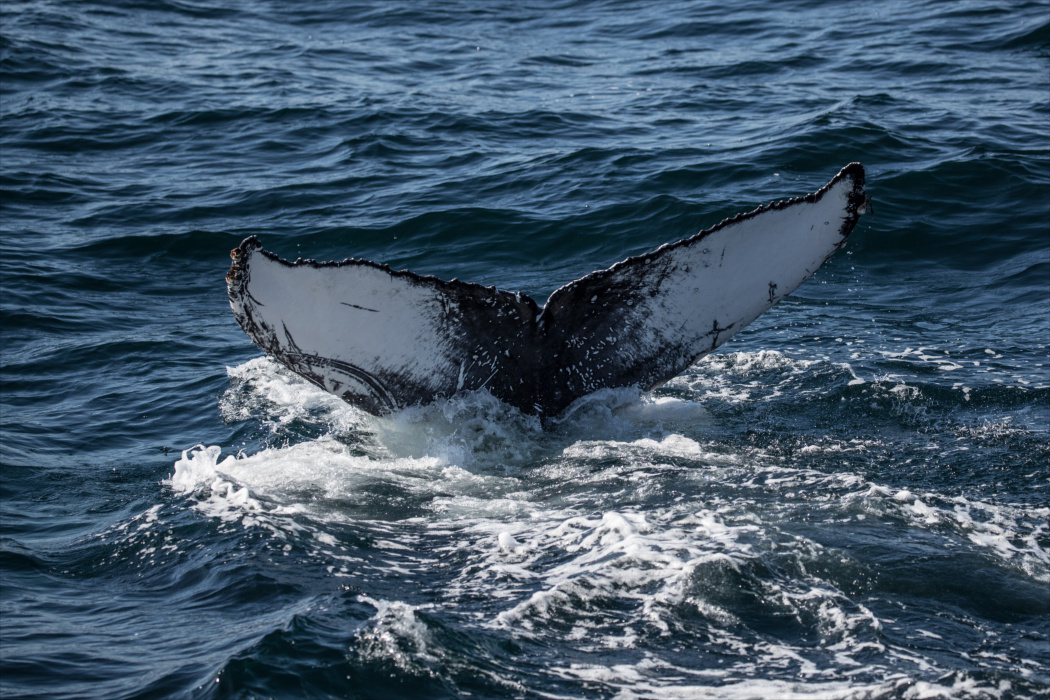

In [48]:
img = PIL.Image.open(fn); img

In [49]:
img.size

(1050, 700)

In [50]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [51]:
row_sz, col_sz = list(zip(*size_d.values()))

In [52]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [53]:
row_sz[:5]

array([1050,  758, 1050, 1050, 1050])

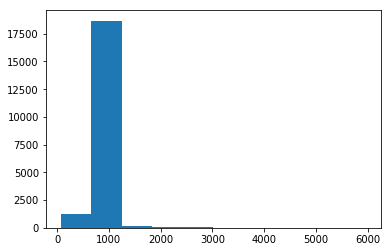

In [54]:
plt.hist(row_sz);

(array([   4.,   41.,   88.,  160.,  317.,  441., 1474.,  585., 1209.,  762.]),
 array([ 77. , 169.2, 261.4, 353.6, 445.8, 538. , 630.2, 722.4, 814.6, 906.8, 999. ]),
 <a list of 10 Patch objects>)

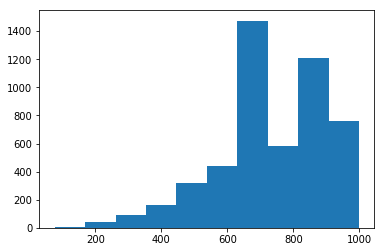

In [55]:
plt.hist(row_sz[row_sz < 1000])

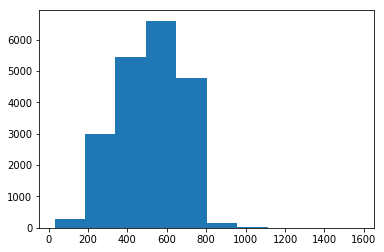

In [56]:
plt.hist(col_sz);

(array([  66.,  595., 2125., 2870., 4137., 5163., 4416.,  760.,  129.,   12.]),
 array([ 30. , 126.9, 223.8, 320.7, 417.6, 514.5, 611.4, 708.3, 805.2, 902.1, 999. ]),
 <a list of 10 Patch objects>)

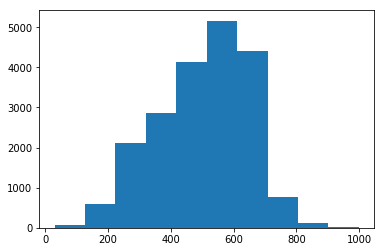

In [57]:
plt.hist(col_sz[col_sz < 1000])

In [58]:
len(data.trn_ds), len(data.test_ds)

(20289, 7960)

In [59]:
len(data.classes), data.classes[:5]

(5005, ['new_whale', 'w_0003639', 'w_0003c59', 'w_0027efa', 'w_00289b1'])

## Initial model

In [33]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train.csv', test_name='test', val_idxs=val_idxs,
                                        tfms=tfms, bs=bs) 
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time


### Precompute

In [34]:
sz = 224
bs = 58

data = get_data(sz, bs)

weigehts need to be dwonloaded
https://forums.fast.ai/t/lesson-2-in-class-discussion/7452/317
fastai/courses/dl1/fastai/weights

In [35]:
learn = ConvLearner.pretrained(arch, data, precompute=True) # takes 16min for resnext, # resnet only 3min

100%|██████████| 138/138 [00:37<00:00,  4.90it/s]


#### Find Learning Rate

 87%|████████▋ | 306/350 [00:03<00:00, 88.00it/s, loss=31.5]


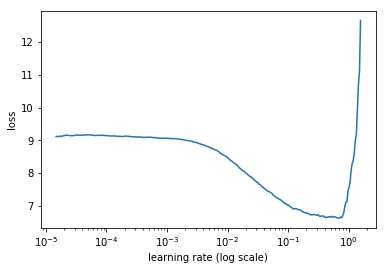

In [36]:
lrf=learn.lr_find()
learn.sched.plot()

In [37]:
lr = 1e-1 

In [38]:
learn.fit(lr, 5)

epoch      trn_loss   val_loss   accuracy   
    0      5.641708   5.473486   0.382689  
    1      5.269607   5.227386   0.388013  
    2      4.88423    5.094736   0.384858  
    3      4.440837   5.111684   0.390379  
    4      4.140839   5.188904   0.358636  



[array([5.1889]), 0.3586356453303753]

### Augment

In [39]:
from sklearn import metrics

In [40]:
data = get_data(sz, bs)

In [41]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [42]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy   
    0      5.616638   5.54807    0.382492  
    1      5.291524   5.269684   0.387421  



[array([5.26968]), 0.38742113383104937]

In [43]:
learn.precompute = False

In [44]:
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      5.065321   5.135809   0.389196  
    1      4.841335   5.063447   0.390773  
    2      4.731181   5.006386   0.392942  
    3      4.641796   4.949061   0.393336  
    4      4.4967     4.922722   0.395899  



[array([4.92272]), 0.3958990536336361]

In [45]:
learn.save('224_pre')

In [46]:
learn.load('224_pre')

## Increase size

In [27]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

In [ ]:
# learn.summary()

In [29]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      5.268464   5.192629   0.388801  
    1      4.918609   5.065151   0.393533  
    2      4.649152   4.964926   0.395505  


[array([4.96493]), 0.3955047331891413]

Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.

In [30]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(lr, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy   
    0      4.526083   4.895356   0.399842  
    1      4.631812   4.839484   0.401222  
    2      3.954476   4.781998   0.405166  
    3      4.366417   4.869077   0.399251  
    4      3.927611   4.799788   0.404377  
    5      3.43334    4.771369   0.411475  
    6      3.124017   4.746992   0.414038  


[array([4.74699]), 0.41403785632917367]

**Seems like we do overfit the data slightly?**

In [ ]:
learn.set_data(get_data(512, bs)) 
learn.freeze()

Orig: Training loss and validation loss are getting closer and smaller. We are on right track.

In [47]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

ValueError: y_true and y_pred contain different number of classes 1955, 5005. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [   0    3    4 ... 4992 4995 5003]

In [48]:
len(data.val_ds.y), data.val_ds.y[:5]

(5072, array([4111, 2751,  710,    0, 2675]))

In [49]:
learn.save('299_pre')

In [50]:
learn.load('299_pre')

In [ ]:
learn.fit(lr, 1, cycle_len=2) # 1+1 = 2 epochs

In [ ]:
learn.save('299_pre')

In [ ]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

This dataset is so similar to ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze.

# DO UNFREEZE !!! !

## Create submission

https://youtu.be/9C06ZPF8Uuc?t=1905

In [51]:
data.classes

['new_whale',
 'w_0003639',
 'w_0003c59',
 'w_0027efa',
 'w_00289b1',
 'w_002c810',
 'w_0032a46',
 'w_003bae6',
 'w_00656c0',
 'w_0066399',
 'w_007fefa',
 'w_00904a7',
 'w_009c9c5',
 'w_00a41ba',
 'w_00b3dc2',
 'w_00d50c9',
 'w_00d5466',
 'w_00d5e98',
 'w_00f340d',
 'w_010f858',
 'w_0115c24',
 'w_0118bab',
 'w_012678c',
 'w_0135f5f',
 'w_0140c92',
 'w_015a4bf',
 'w_016f0ea',
 'w_0182687',
 'w_0189b6d',
 'w_01976db',
 'w_01a1d88',
 'w_01cb0c4',
 'w_01cbbbd',
 'w_01d790e',
 'w_01e1b97',
 'w_01e1fe0',
 'w_01ed442',
 'w_01f14e1',
 'w_01fc429',
 'w_02156b0',
 'w_022b708',
 'w_022d2f5',
 'w_02469a1',
 'w_02545ea',
 'w_025911c',
 'w_0277a07',
 'w_027f528',
 'w_0292e15',
 'w_02aa597',
 'w_02c7e9d',
 'w_02d138d',
 'w_02d5c46',
 'w_02e8199',
 'w_02ff6d6',
 'w_0301302',
 'w_030ac9b',
 'w_030c8b0',
 'w_030e2cf',
 'w_03193e5',
 'w_031e1a3',
 'w_0323574',
 'w_03270e3',
 'w_0350bf4',
 'w_03670aa',
 'w_0369a5c',
 'w_036bc54',
 'w_036dbd0',
 'w_037b23f',
 'w_038dfc0',
 'w_038e5c3',
 'w_03a82c1',
 'w_03

In [52]:
data.test_ds.fnames

['test/cefc2476f.jpg',
 'test/272146b21.jpg',
 'test/7b43451f9.jpg',
 'test/3d5903acc.jpg',
 'test/5f020ae50.jpg',
 'test/867703d75.jpg',
 'test/6bdcf9f09.jpg',
 'test/6f3b5ffd4.jpg',
 'test/3de1ca0ad.jpg',
 'test/ea2ee400a.jpg',
 'test/c6bbca287.jpg',
 'test/0133056d1.jpg',
 'test/7e060c7d6.jpg',
 'test/b18ea8b07.jpg',
 'test/8ecb4b78b.jpg',
 'test/2ee0018dd.jpg',
 'test/b033e4d71.jpg',
 'test/537d53e92.jpg',
 'test/585462a2f.jpg',
 'test/97f72805f.jpg',
 'test/a059b6584.jpg',
 'test/dda9b2bd9.jpg',
 'test/0cbfdf671.jpg',
 'test/92790ce15.jpg',
 'test/ac7350385.jpg',
 'test/a79ddd84d.jpg',
 'test/5657d8f3d.jpg',
 'test/fc734b316.jpg',
 'test/6e519a8cf.jpg',
 'test/1a4b25e55.jpg',
 'test/3afb07efb.jpg',
 'test/5402ecfe8.jpg',
 'test/cef1ce25f.jpg',
 'test/e80fb0992.jpg',
 'test/88b01bae2.jpg',
 'test/f641c44c8.jpg',
 'test/cfeae6723.jpg',
 'test/a4e17c500.jpg',
 'test/e01de7c87.jpg',
 'test/9b9354192.jpg',
 'test/41fdd6353.jpg',
 'test/7834ce05d.jpg',
 'test/fbe59ed5d.jpg',
 'test/3b6d

In [ ]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)
#accuracy_np(probs, y), metrcs.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [53]:
probs.shape # (n_images, n_classes)

(5072, 5005)

In [54]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [76]:
[o[5:] for o in data.test_ds.fnames];
df.head();

def convert_preds_to_names(df, classes):
    return df
    
    
convert_preds_to_names(probs[0], data.classes)

AttributeError: 'numpy.float32' object has no attribute 'column'

In [61]:
df.insert(0, 'id', [o[5:] for o in data.test_ds.fnames])

ValueError: Length of values does not match length of index

In [ ]:
df.head()

In [ ]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [ ]:
FileLink(f'{SUBM}subm.gz')

## Individual prediction

In [ ]:
fn = data.val_ds.fnames[0]
fn

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

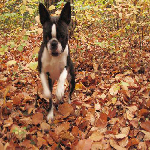

In [ ]:
Image.open(PATH + fn).resize((150, 150))

In [ ]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

19

In [ ]:
learn.data.classes[np.argmax(preds)]

'boston_bull'

In [ ]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)

19